## Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
from geopy.distance import geodesic

## Import Cleaned Dataset From EDA Part 1 

In [3]:
%%time
# Taxi trip data 
train = pd.read_csv("Training_FeatureEngineering(borough).2_0.csv",skipinitialspace=True)
train.head()

CPU times: user 1min 34s, sys: 31.8 s, total: 2min 6s
Wall time: 2min 5s


In [6]:
train.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'payment_type', 'fare_amount', 'surcharge',
       'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'pickup_date',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'pickup_month',
       'pickup_year', 'trip_time', 'drive_speed', 'fare_amount_per_minute',
       'earning', 'earning_per_minute', 'fare_amount_per_mile',
       'is_pickup_EWR', 'is_dropoff_EWR', 'is_pickup_JFK', 'is_dropoff_JFK',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia',
       'is_outlier_fare_per_mile', 'earning_amount', 'earning_per_mile',
       'pickup_borough', 'dropoff_borough'],
      dtype='object')

### 1. Now York City boroughs

In [8]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007
    },
    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395
    },
    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176
    },
    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490
    }    
}

In [221]:
def getBorough(lat,lng): 
    locs = nyc_boroughs.keys()
    for loc in locs:
        if lat >= nyc_boroughs[loc]['min_lat'] and lat <= nyc_boroughs[loc]['max_lat'] and lng >= nyc_boroughs[loc]['min_lng'] and lng <= nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'



In [222]:
train['pickup_borough'] = train.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis = 1)
train['dropoff_borough'] = train.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis = 1)


In [223]:
train.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'payment_type', 'fare_amount', 'surcharge',
       'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'pickup_date',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'pickup_month',
       'pickup_year', 'trip_time', 'drive_speed', 'fare_amount_per_minute',
       'earning', 'earning_per_minute', 'fare_amount_per_mile',
       'is_pickup_EWR', 'is_dropoff_EWR', 'is_pickup_JFK', 'is_dropoff_JFK',
       'is_pickup_la_guardia', 'is_dropoff_la_guardia',
       'is_outlier_fare_per_mile', 'earning_amount', 'earning_per_mile',
       'pickup_borough', 'dropoff_borough'],
      dtype='object')

In [9]:
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly

total_len=len(train)
def plot_bar_chart(data,xasis_label,yaxis_label,title,percent=False):
    
    traces = []
    annotations = []
    for i in range(0,len(data)):   
        trace = {
          'x': [data.index[i]],
          'y': [data[i]],
          'name': str(data.index[i]),
          'type': 'bar'
        }
        percentage = str(round((data[i] / total_len) * 100,2)) + '%'
        annotations.append(dict(x=data.index[i],y=data[i]+300000,text=percentage, font=dict(family='Arial', size=14,
                            color='black'),
                                  showarrow=False,))
        traces.append(trace)
        
    
    if percent:
        layout = {
          'xaxis': {'title': xasis_label},
          'yaxis': {'title': yaxis_label},
          'barmode': 'relative',
          'title': title,
            'annotations' : annotations
        };
    else:
        layout = {
          'xaxis': {'title': xasis_label},
          'yaxis': {'title': yaxis_label},
          'barmode': 'relative',
          'title': title
        };        
    return py.iplot({'data': traces, 'layout': layout}, filename='barmode-relative')

In [12]:
trip_count_by_hour = train.groupby(['pickup_borough'])['passenger_count'].count()
plot_bar_chart(trip_count_by_hour,'Hour','Number of Trips','Number of Trips by Hour',percent = True)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~maki83794676/0 or inside your plot.ly account where it is named 'barmode-relative'


In [13]:
trip_count_by_hour = train.groupby(['dropoff_borough'])['passenger_count'].count()
plot_bar_chart(trip_count_by_hour,'Hour','Number of Trips','Number of Trips by Hour',percent = True)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~maki83794676/0 or inside your plot.ly account where it is named 'barmode-relative'


In [14]:
surcharge_L = train['pickup_borough'].value_counts().sort_index()
print(surcharge_L)

bronx            11069   
brooklyn         54355   
manhattan        11248941
others           1600    
queens           2352274 
staten_island    440     
Name: pickup_borough, dtype: int64


In [15]:
surcharge_L = train['dropoff_borough'].value_counts().sort_index()
print(surcharge_L)

bronx            63450   
brooklyn         144662  
manhattan        10875200
others           7203    
queens           2576811 
staten_island    1353    
Name: dropoff_borough, dtype: int64


In [229]:
train_heatmap = train[['fare_amount','rate_code','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_borough','dropoff_borough']]


In [230]:
train_heatmap.to_csv("Visualisation.2_0.csv",index=False)

### 2. In the scatter plot, we saw the high density of pickups and dropoffs from and to JFK and La Guardia Airport
Let us look at over time how fares are from La Guardia and JFK

In [6]:
JFK = {'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
JFK_center = [40.6437,-73.7900]
# Get all pickups to JFK
JFK_pickup = train.loc[(train.pickup_latitude >= JFK['min_lat']) & (train.pickup_latitude <= JFK['max_lat'])]
JFK_pickup = JFK_pickup.loc[(train.pickup_longitude >= JFK['min_lng']) & (train.pickup_longitude <= JFK['max_lng'])]

print("Number of Trips with Pickups from JFK",JFK_pickup.shape[0])
# Get all dropoffs to JFK
JFK_dropoff = train.loc[(train.dropoff_latitude >= JFK['min_lat']) & (train.dropoff_latitude <= JFK['max_lat'])]
JFK_dropoff = JFK_dropoff.loc[(train.dropoff_longitude >= JFK['min_lng']) & (train.dropoff_longitude <= JFK['max_lng'])]

print("Number of Trips with Dropoffs to JFK",JFK_dropoff.shape[0])
    

Number of Trips with Pickups from JFK 112087
Number of Trips with Dropoffs to JFK 44269


**What is the Average Fare amount of trips from JFK**

Text(0.5, 1.0, 'Fare Amount Distribution')

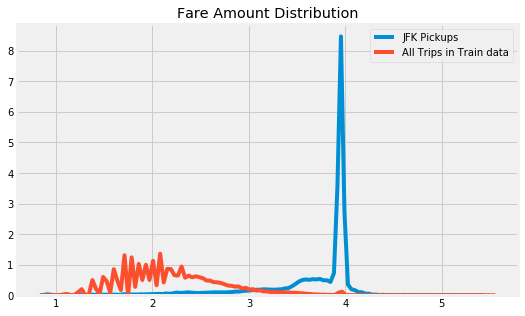

In [7]:
plt.figure(figsize = (8,5))
sns.kdeplot(np.log(JFK_pickup['fare_amount'].values),label = 'JFK Pickups')
#sns.kdeplot(np.log(JFK_dropoff['fare_amount'].values),label='JFK Dropoff')
sns.kdeplot(np.log(train['fare_amount'].values),label = 'All Trips in Train data')
plt.title("Fare Amount Distribution")

As we can see, the fare amount is much higher when pickup is from JFK.

Text(0.5, 1.0, 'Dropoffs vs Fare Amount')

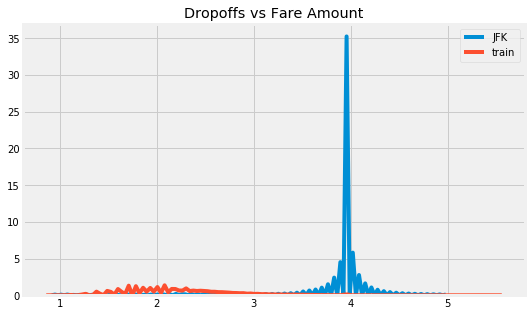

In [8]:
plt.figure(figsize = (8,5))
sns.kdeplot(np.log(JFK_dropoff['fare_amount'].values),label = 'JFK')
sns.kdeplot(np.log(train['fare_amount'].values),label = 'train')
plt.title("Dropoffs vs Fare Amount")

In [9]:
del JFK_data
del JFK
del JFK_dropoff

 Distribution of fare amount for  both pickup and dropoff to JFK is similar

The fare seems to be fixed for trip distances > 50 miles. Normally airports pickup or dropoff have fixed prices.
We can remove the airport pickup and dropoff and plot the distribution of Fare Amount vs Trip distribution 

In [11]:
%%time
non_airport=train.loc[(train['is_dropoff_JFK'] == 0) & (train['is_dropoff_EWR'] == 0) & (train['is_dropoff_la_guardia'] == 0)]
non_airport=non_airport.loc[(non_airport['is_pickup_JFK'] == 0) & (non_airport['is_pickup_EWR'] == 0) & (non_airport['is_pickup_la_guardia'] == 0)]
non_airport.shape

CPU times: user 11.5 s, sys: 26.7 s, total: 38.2 s
Wall time: 47.5 s


Text(0.5, 1.0, 'Trip Distance vs Fare Amount (excluding airport rides)')

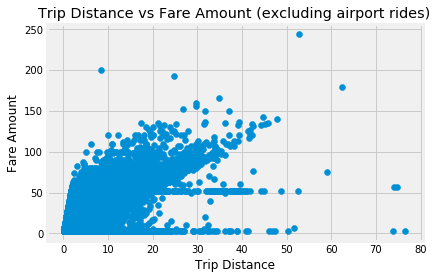

In [12]:
plt.scatter(x = non_airport['trip_distance'],y = non_airport['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (excluding airport rides)")

New York city is divided into 5 Boroughs. Let us calculate which borough pickup and dropoff points are. And whether that effects the fare

In [24]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },    
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007
    },

    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395
    },

    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176
    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490
    }    
}

In [25]:
def getBorough(lat,lng):
    
    locs = nyc_boroughs.keys()
    for loc in locs:
        if lat >= nyc_boroughs[loc]['min_lat'] and lat <= nyc_boroughs[loc]['max_lat'] and lng >= nyc_boroughs[loc]['min_lng'] and lng <= nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'

        

In [ ]:
train['pickup_borough'] = train.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis = 1)
train['dropoff_borough'] = train.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis = 1)


### How does the tripfare vary across buroughs

Text(0.5, 1.0, 'Distribution of Pickup Boroughs')

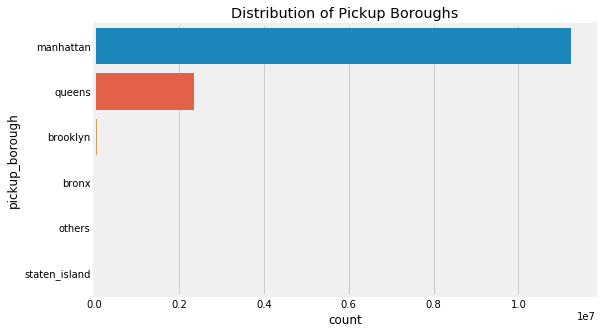

In [22]:
plt.figure(figsize = (8,5))
sns.countplot(y = train['pickup_borough'])
plt.title("Distribution of Pickup Boroughs")

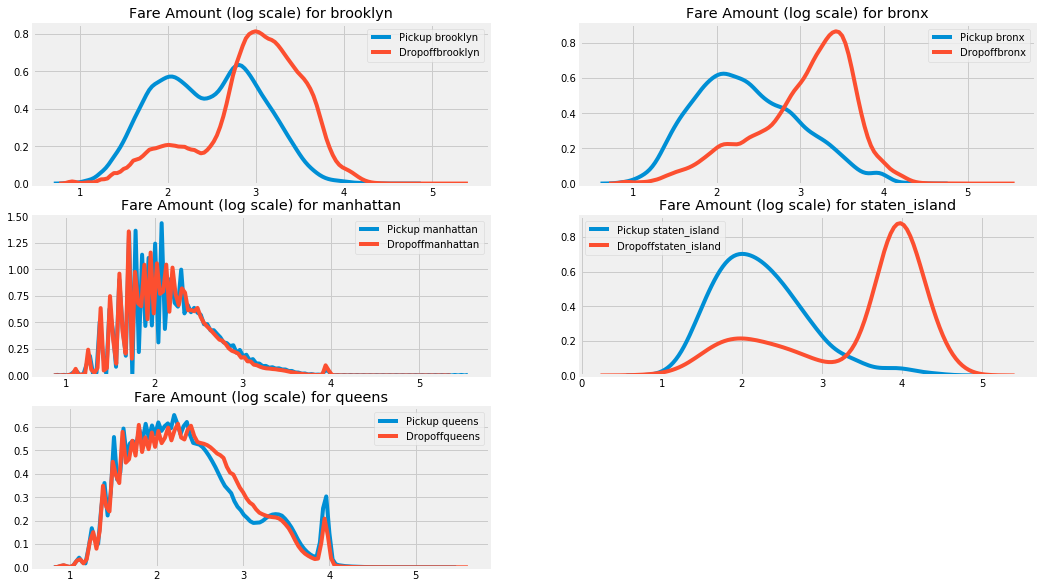

In [26]:


plt.figure(figsize = (16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i = 1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough'] == key,'fare_amount'].values),label = 'Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough'] == key,'fare_amount'].values),label = 'Dropoff'+ key).set_title("Fare Amount (log scale) for " + key)
    
    i = i + 1


There is a significant difference in pickups and dropoffs fare amount for each burough exceept Manhattan and Queens. We can see pickups from bronx, staten_island and brooklyn is expensive compared to pickups from other Buroughs.Very high difference in pickup and dropoff prices for Bronx, Staten Island and Brooklyn.

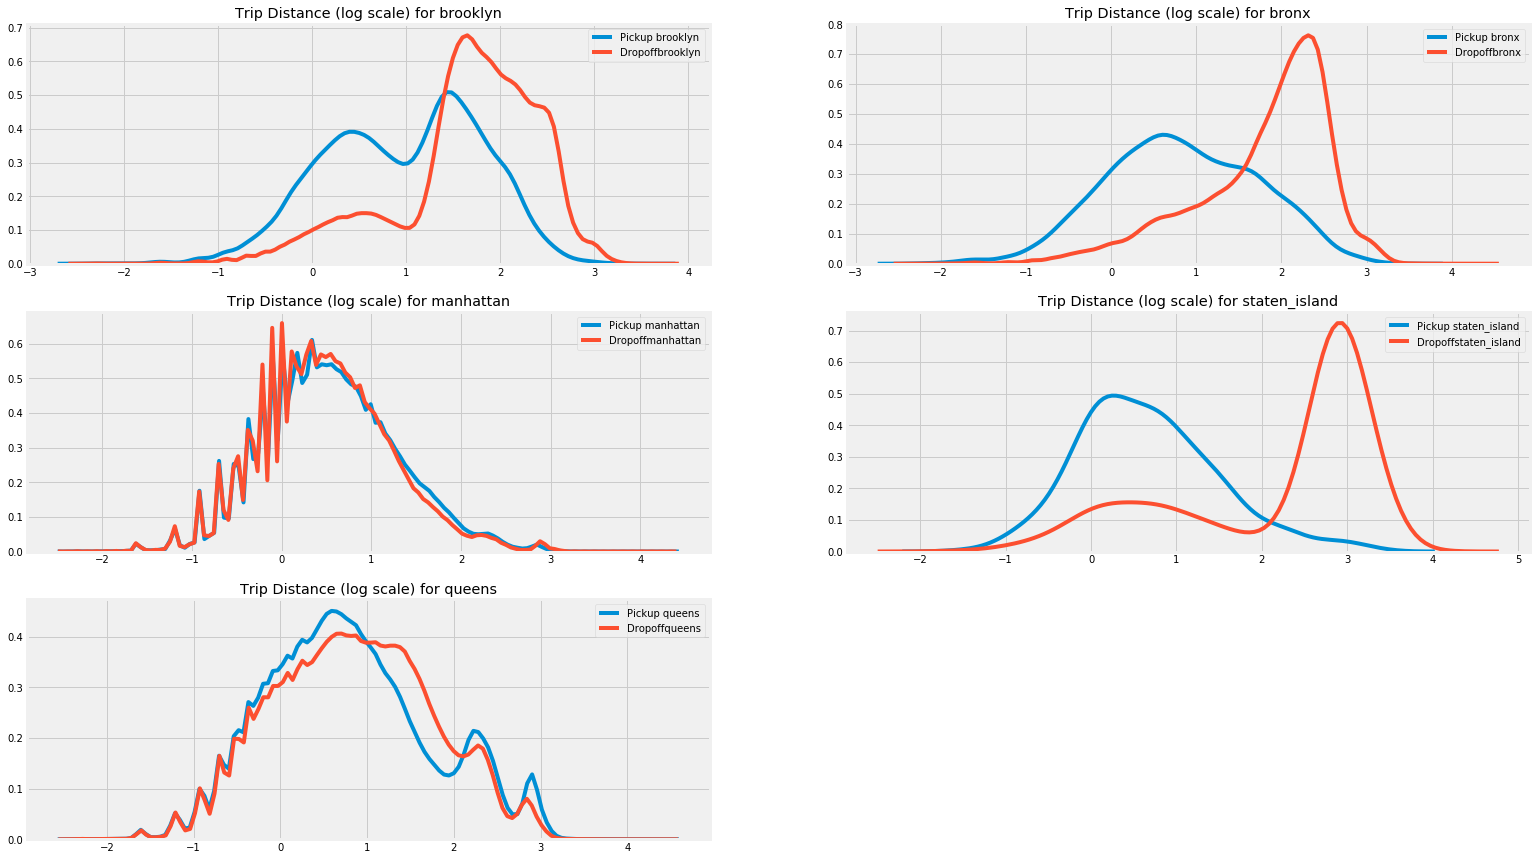

In [27]:
plt.figure(figsize=(24,15))
plt.title("Distribution of Trip Distances Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'trip_distance'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'trip_distance'].values),label='Dropoff'+ key).set_title("Trip Distance (log scale) for "+key)
    i=i+1

Dropoffs to Bronx and Staten island are long trips. In Manhattan the pickup and dropoffs fare amount has similar distribution. Let us add a field, is_lower_manhattan as we had seen above that dropoffs to lower manhattan had higher trip distance but lower fare

In [28]:
lower_manhattan_boundary = {'min_lng': -74.0194,
                          'min_lat':40.6997,
                          'max_lng':-73.9716,
                          'max_lat':40.7427}

def isLowerManhattan(lat,lng):
    if lat >= lower_manhattan_boundary['min_lat'] and lat <= lower_manhattan_boundary['max_lat'] and lng >= lower_manhattan_boundary['min_lng'] and lng <= lower_manhattan_boundary['max_lng']:
        return 1
    else:
        return 0
    

In [29]:
train['is_pickup_lower_manhattan'] = train.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis = 1)
train['is_dropoff_lower_manhattan'] = train.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis = 1)

**How does Fare Amount differ for pickups and dropoff for Lower Manhattan compared to rest of Manhattan**

In [46]:
manhattan = train.loc[(train['pickup_borough'] == 'manhattan') | (train['dropoff_borough'] == 'manhattan')]
manhattan.shape

(12707181, 46)

Text(0.5, 1.0, 'Distribution of Fare Amount - Manhattan vs Lower Manhattan')

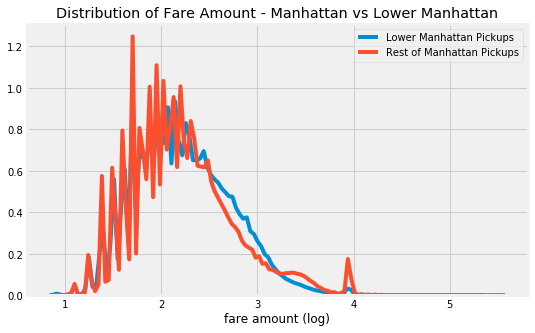

In [31]:
plt.figure(figsize = (8,5))
sns.kdeplot(np.log(manhattan.loc[manhattan['is_pickup_lower_manhattan'] == 1,'fare_amount'].values),label = 'Lower Manhattan Pickups')
sns.kdeplot(np.log(manhattan.loc[manhattan['is_pickup_lower_manhattan'] == 0,'fare_amount'].values),label = 'Rest of Manhattan Pickups')
plt.xlabel("fare amount (log)")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

Text(0.5, 1.0, 'Distribution of Fare Amount - Manhattan vs Lower Manhattan')

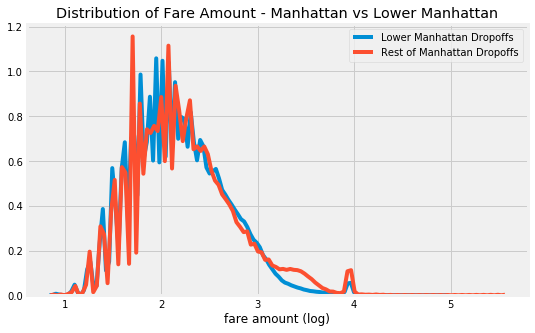

In [32]:
plt.figure(figsize = (8,5))
sns.kdeplot(np.log(manhattan.loc[manhattan['is_dropoff_lower_manhattan'] == 1,'fare_amount'].values),label = 'Lower Manhattan Dropoffs')
sns.kdeplot(np.log(manhattan.loc[manhattan['is_dropoff_lower_manhattan'] == 0,'fare_amount'].values),label = 'Rest of Manhattan Dropoffs')
plt.xlabel("fare amount (log)")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Lower Manhattan pickups)')

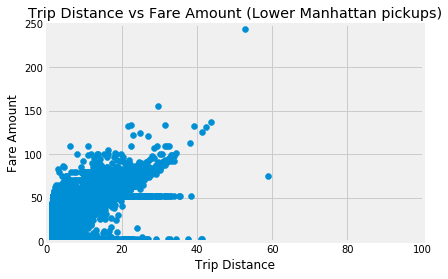

In [41]:
plt.scatter(x = manhattan.loc[manhattan['is_pickup_lower_manhattan'] == 1,'trip_distance'].values,y = manhattan.loc[manhattan['is_pickup_lower_manhattan'] == 1,'fare_amount'].values)
plt.xlim(0, 100)
plt.ylim(0, 250)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan pickups)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Rest of Manhattan pickups)')

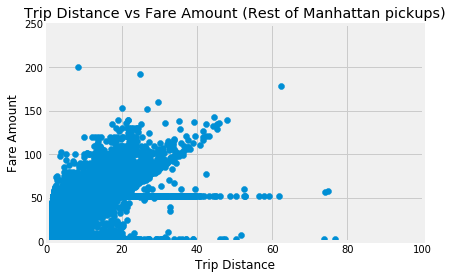

In [42]:
plt.scatter(x = manhattan.loc[manhattan['is_pickup_lower_manhattan'] == 0,'trip_distance'].values,y = manhattan.loc[manhattan['is_pickup_lower_manhattan'] == 0,'fare_amount'].values)
plt.xlim(0, 100)
plt.ylim(0, 250)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan pickups)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Lower Manhattan dropoffs)')

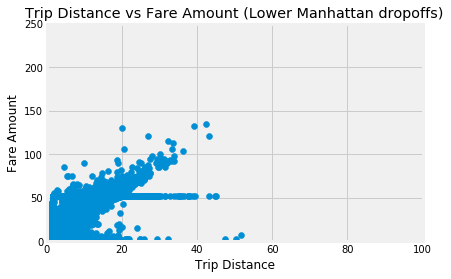

In [47]:
plt.scatter(x = manhattan.loc[manhattan['is_dropoff_lower_manhattan'] == 1,'trip_distance'].values,y = manhattan.loc[manhattan['is_dropoff_lower_manhattan'] == 1,'fare_amount'].values)
plt.xlim(0, 100)
plt.ylim(0, 250)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan dropoffs)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Rest of Manhattan dropoffs)')

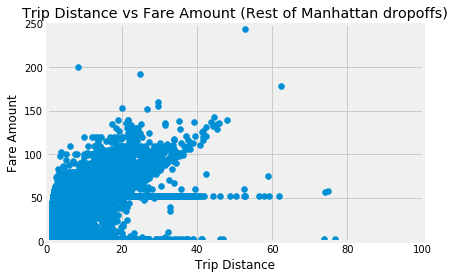

In [48]:
plt.scatter(x = manhattan.loc[manhattan['is_dropoff_lower_manhattan'] == 0,'trip_distance'].values,y = manhattan.loc[manhattan['is_dropoff_lower_manhattan'] == 0,'fare_amount'].values)
plt.xlim(0, 100)
plt.ylim(0, 250)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan dropoffs)")


The distribution of trip distance and fare amount for Lower Manhattan pickups and dropoffs is very different. Also, slope of linear realtionship for pickups for Lower Manhattan is higher than that for Rest of Manhattan

#### Calculate percentage of night shifts for each taxi driver
Day shift is defined from 5am to 4pm pickup time. Night shift is defined from 5pm to 4am pickup time

In [16]:
train.loc[( train['pickup_hour'].isin([5,6,7,8,9,10,11,12,13,14,15,16]) ),'is_night_shift']=0
train.loc[( train['pickup_hour'].isin([17,18,19,20,21,22,23,0,1,2,3,4]) ),'is_night_shift']=1

In [20]:
driver_total_days_worked = train[['hack_license','pickup_date']].groupby(['hack_license'])['pickup_date'].nunique()
driver_total_income = train[['hack_license','earning']].groupby(['hack_license'])['earning'].sum()
driver_daily_income_avg = driver_total_income / driver_total_days_worked
driver_daily_income_avg.head()

hack_license
0002555BBE359440D6CEB34B699D3932    229.105185
0008B3E338CE8C3377E071A4D80D3694    225.698000
000A4EBF1CEB9C6BD9978D4362493C6E    202.552083
000B8D660A329BBDBF888500E4BD8B98    247.017500
000C15EFBDF58CAED528C09E597484EC    276.925000
dtype: float64

In [17]:
driver_night_shifts = train[['hack_license','is_night_shift']].groupby(['hack_license'])['is_night_shift'].sum()
driver_total_shifts = train[['hack_license','is_night_shift']].groupby(['hack_license'])['is_night_shift'].count()
driver_night_shifts_ratio = driver_night_shifts / driver_total_shifts
driver_night_shifts_ratio.head()

hack_license
0002555BBE359440D6CEB34B699D3932    0.976344
0008B3E338CE8C3377E071A4D80D3694    0.998069
000A4EBF1CEB9C6BD9978D4362493C6E    0.997110
000B8D660A329BBDBF888500E4BD8B98    1.000000
000C15EFBDF58CAED528C09E597484EC    0.984733
Name: is_night_shift, dtype: float64

#### Distribution of night shift percentage

count    31935.00
mean     0.49    
std      0.42    
min      0.00    
25%      0.02    
50%      0.50    
75%      0.95    
max      1.00    
Name: is_night_shift, dtype: float64

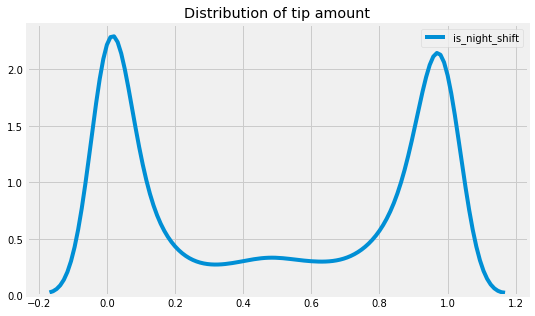

In [18]:
plt.figure(figsize=(8,5))
sns.kdeplot(driver_night_shifts_ratio).set_title("Distribution of tip amount")
driver_night_shifts_ratio.describe().round(2)

#### The scatter plot below shows that daily income of taxi drivers have almost no correlation with the percentage of night shifts they take

Text(0.5, 1.0, 'Daily income vs Percentage of night shitfs')

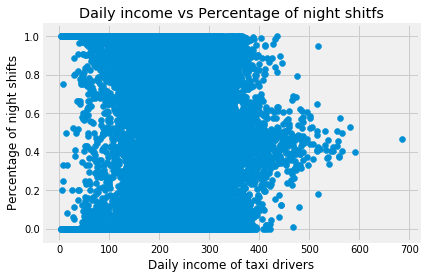

In [21]:
plt.scatter(x=driver_daily_income_avg,y=driver_night_shifts_ratio)
plt.xlabel("Daily income of taxi drivers")
plt.ylabel("Percentage of night shifts")
plt.title("Daily income vs Percentage of night shitfs")